In [1]:
from utils import *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
import torch
import torchvision.datasets as ds
import torchvision.transforms.functional as ttf
import random
import joblib

2024-01-22 16:13:30.974475: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-22 16:13:31.477123: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-22 16:13:35.214012: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/weifanw/.conda/envs/fam/lib/python3.10/site-packages/cv2/../../lib64:
2024-01-22 16:13:35.214367: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_p

In [2]:
cif = ds.CIFAR100('E:\Dataset\common', download=True)

Files already downloaded and verified


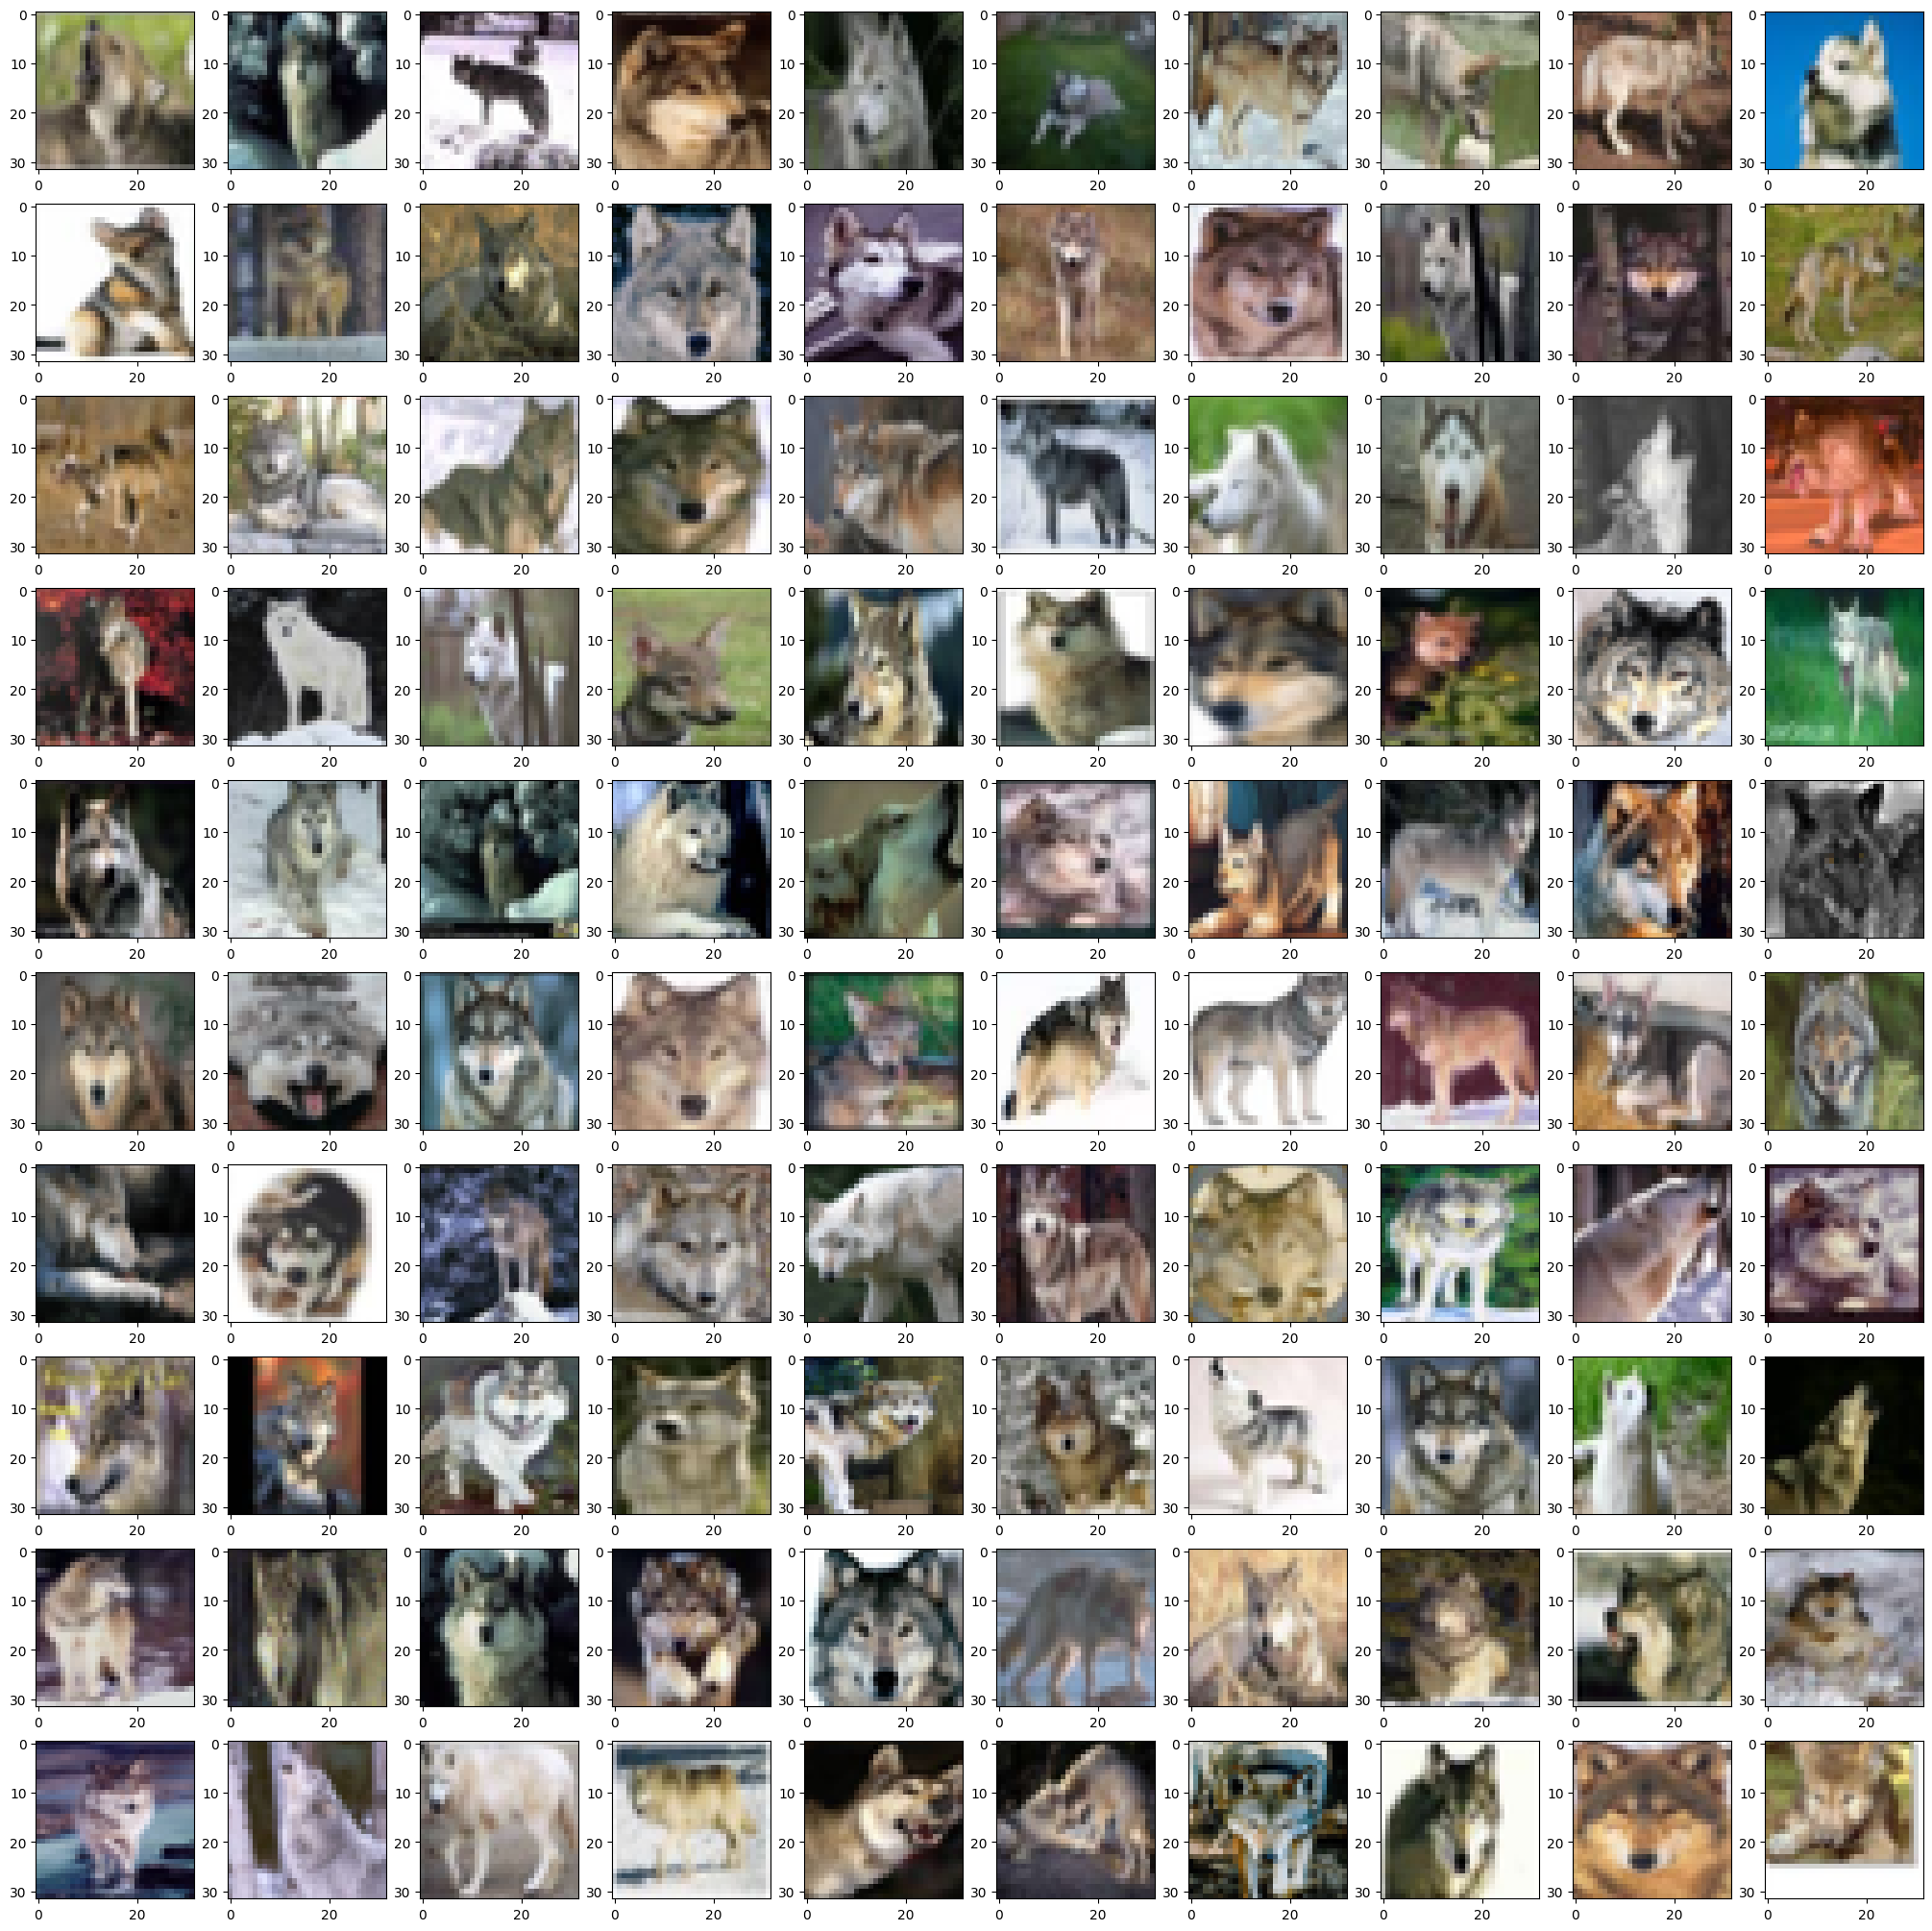

In [3]:
i, j = 0, 0
imgs = []
while True:
    img, c = cif[j]
    j += 1
    if c == 97:
        imgs.append(img)
        i += 1
    if i >= 100:
        break

fig, axs = plt.subplots(10, 10, constrained_layout=True, figsize=(20, 20))
axs = axs.flatten()
for img, ax in zip(imgs, axs):
    ax.imshow(img)

In [9]:
num_kernel = 64
num_row = 8
num_col = 8
H, W = 32, 32
# overlap = 4
filter_size = [9, 9]
num_stimuli = 5

In [5]:
def test_noise_continuum(dataset, grad_step=1, std_threshold=0.2):
    # construct noise corpus
    orig_shape = ttf.to_tensor(dataset[0][0]).shape  
    idx_all = np.arange(orig_shape[1] * orig_shape[2])
    idx_corrupt = [np.random.choice(idx_all, int(len(idx_all) * p / 100), False) for _ in range(5) for p in range(0, 90, grad_step)]
    corrupt_pattern = [torch.rand(len(idx_corrupt[i])) for i in range(len(idx_corrupt))]
    
    imgs, labels = [], []
    count, i = 0, 0
    while True:
        img, label = dataset[i]
        i += 1
        img = ttf.to_tensor(img)
        img = ttf.rgb_to_grayscale(img).movedim(0, -1)
        # check std
        if torch.std(img, unbiased=True) <= std_threshold:
            continue
        # noise corruption
        continuum = []
        for idx, pattern in zip(idx_corrupt, corrupt_pattern):
            noise_img = img.clone().flatten()
            noise_img[idx] = pattern
            ni = noise_img.clone().reshape(*img.shape)
            continuum.append(ni)
        imgs.append(torch.stack(continuum).reshape(5, 90 // grad_step, img.shape[0], img.shape[1], 1).swapdims(0, 1))
        labels.append(label)
        count += 1
        if count >= num_stimuli:
            break
    return torch.stack(imgs).detach().numpy(), labels

In [6]:
test_imgs, test_labels = test_noise_continuum(cif)
test_imgs.shape

(3, 90, 5, 32, 32, 1)

In [ ]:
fig, axs = plt.subplots(7, 7, constrained_layout=True, figsize=(14, 14))
axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.imshow(test_imgs[3, i].squeeze(), cmap='gray')
    ax.set_title(f'{2 * i}% noise')

In [ ]:
fig, axs = plt.subplots(90, 5, constrained_layout=True, figsize=(5, 90))
for i in range(90):
    for j in range(5):
        axs[i, j].imshow(test_imgs[0, i, j].squeeze(), cmap='gray')

In [6]:
def train_noise_continuum(dataset, grad_step=10, std_threshold=0.2):
    imgs, labels = [], []
    
    # construct noise corpus
    orig_shape = ttf.to_tensor(dataset[0][0]).shape  
    idx_all = np.arange(orig_shape[1] * orig_shape[2])
    idx_corrupt = [np.random.choice(idx_all, int(len(idx_all) * p / 100), False) for _ in range(10) for p in range(0, 100, grad_step)]
    corrupt_pattern = [torch.rand(len(idx_corrupt[i])) for i in range(len(idx_corrupt))]

    count, i = 0, 0
    while True:
        img, label = dataset[i]
        i += 1
        img = ttf.to_tensor(img)
        img = ttf.rgb_to_grayscale(img).movedim(0, -1)
        # check std
        if torch.std(img, unbiased=True) <= std_threshold:
            continue
        # noise corruption
        continuum = []
        for idx, pattern in zip(idx_corrupt, corrupt_pattern):
            noise_img = img.clone().flatten()
            noise_img[idx] = pattern
            ni = noise_img.clone().reshape(*img.shape)
            continuum.append(ni)
        imgs.append(torch.stack(continuum).reshape(100 // grad_step, 10, img.shape[0], img.shape[1], 1).swapdims(0, 1))
        labels.append(label)
        count += 1
        if count >= num_stimuli:
            break
    return torch.stack(imgs).detach().numpy(), labels

In [7]:
train_imgs, train_labels = train_noise_continuum(cif)
train_imgs.shape

(20, 10, 10, 32, 32, 1)

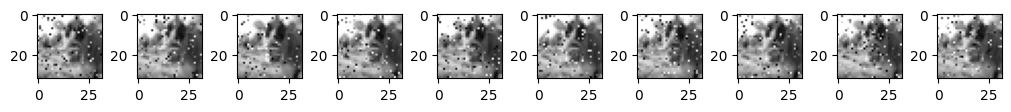

In [34]:
fig, axs = plt.subplots(1, 10, constrained_layout=True, figsize=(10, 1))
for j, ax in enumerate(axs):
    ax.imshow(train_imgs[0, 1, j].squeeze(), cmap='gray')

#### Encode

In [2]:
# Get kernels
filters = np.load("filter_256.npy")

In [3]:
# 64 filters used for experiments
filter_list = [113, 233,  51,  28,  64,  62,  56, 252, 229, 125, 213,  23,  90, 91, 127,  63, 176,  75,   8,  97, 106, 162, 105, 247, 204,  58, 87,  82,   1, 108,  96, 250,  76,  69, 216, 217,  81, 211, 160,3, 155, 147, 169, 199,  17, 207, 215, 232,  86,  84,  72, 152, 218, 136, 178, 158,  10,  48, 139, 187, 230, 253, 180, 146]

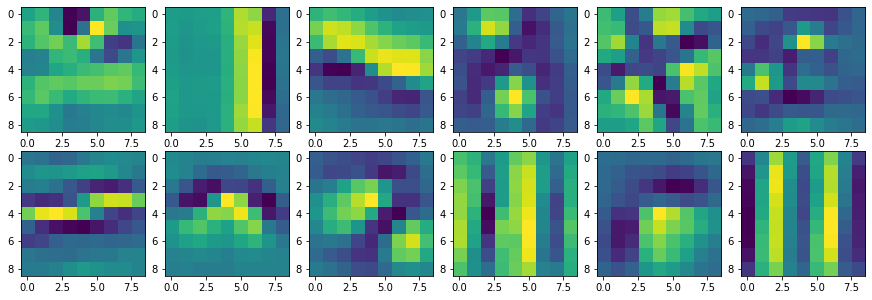

In [12]:
fig, axs = plt.subplots(2, 6, constrained_layout=True, figsize=(12, 4))
axs = axs.flatten()
for i, filter in enumerate(filters[filter_list][:12]):
    axs[i].imshow(filter.reshape(9, 9))

plt.show()

In [4]:
test_imgs = np.load('SMT-BCM_input_correct/X_cifar5_all_noise.npy')

In [5]:
test_imgs.shape

(5, 4, 10, 32, 32)

In [10]:
response = []
imgs = test_imgs.reshape(-1, H, W, 1)
for i, n in enumerate(filters[filter_list]):
    kernel = n.reshape(9,9,1,1)
    # tmp = (tf.nn.conv2d(imgs, kernel, strides=[1, 4, 4, 1], padding='VALID').numpy()).reshape(num_stimuli, num_row, num_col)
    tmp = tf.nn.conv2d(imgs, kernel, strides=[1, 3, 3, 1], padding='VALID').numpy()
    tmp = tmp.squeeze()
    response.append(tmp)
response = np.stack(response).transpose(1, 0, 2, 3).reshape(num_stimuli, -1, 10, num_kernel, num_row, num_col)

In [12]:
# r_in = np.absolute(response)
r_in = np.abs(response)
# r_in *= 60
r_in.shape

(5, 4, 10, 64, 8, 8)

In [13]:
np.save('SMT-BCM_input_correct/r_in_cifar_all_noise_abs_5_4_10_64_8_8.npy', r_in)

In [27]:
response = []
imgs = train_imgs.reshape(-1, H, W, 1)
for i, n in enumerate(filters[filter_list]):
    kernel = n.reshape(9,9,1,1)
    # tmp = (tf.nn.conv2d(imgs, kernel, strides=[1, 4, 4, 1], padding='VALID').numpy()).reshape(num_stimuli, num_row, num_col)
    tmp = tf.nn.conv2d(imgs, kernel, strides=[1, 3, 3, 1], padding='VALID').numpy()
    tmp = tmp.squeeze()
    response.append(tmp)
response = np.stack(response).transpose(1, 0, 2, 3).reshape(num_stimuli, -1, 10, num_kernel, num_row, num_col)

In [28]:
# r_in = np.absolute(response)
r_in = np.abs(response)
# r_in *= 60
r_in.shape

(20, 10, 10, 64, 8, 8)

In [29]:
np.save('cifarNoiseContinuumTrain_abs_20_10_10_64_8_8.npy', r_in)